# ANN to Predict a Quadrant
Using modal representation, can we imrprove on Santamaria-Granados, Luz, et al. "Using deep convolutional neural network for emotion detection on a physiological signals dataset (AMIGOS)." IEEE Access 7 (2018): 57-67.

Another step forward from fingerprints, single subject??

All, w\ augmentation, discrete

Setup: Javascript and ipynb stuff

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
%%javascript
utils.load_extension('collapsible_headings/main')
utils.load_extension('hide_input/main')
utils.load_extension('autosavetime/main')
utils.load_extension('execute_time/ExecuteTime')
utils.load_extension('code_prettify/code_prettify')
utils.load_extension('scroll_down/main')
utils.load_extension('jupyter-js-widgets/extension')

<IPython.core.display.Javascript object>

## Load Functions

In [2]:
from fastai.vision import *
import os
import numpy as np
import pandas as pd
import pickle
import warnings; warnings.simplefilter('ignore')

In [3]:
path=pathlib.Path('/home/tris/Documents/EEG_data/DMD_DEAP')
path

PosixPath('/home/tris/Documents/EEG_data/DMD_DEAP')

## Load Original Data Labels

In [4]:
path = '/media/tris/tris_files/EEG_datasets/DEAP_data_preprocessed_python/s01.dat'
df_read = pickle.load(open(path, 'rb'), encoding='latin1')
labels=df_read['labels']
df_tmp = pd.DataFrame(labels, columns=['valence','arousal','dominance','liking'])
df=df_tmp
for n in range (2,10):
    path = '/media/tris/tris_files/EEG_datasets/DEAP_data_preprocessed_python/s0'+str(n)+'.dat'
    df_read = pickle.load(open(path, 'rb'), encoding='latin1')
    labels=df_read['labels']
    df_tmp = pd.DataFrame(labels, columns=['valence','arousal','dominance','liking'])
    df=df.append(df_tmp, ignore_index=True)
for n in range (10,33):
    path = '/media/tris/tris_files/EEG_datasets/DEAP_data_preprocessed_python/s'+str(n)+'.dat'
    df_read = pickle.load(open(path, 'rb'), encoding='latin1')
    labels=df_read['labels']
    df_tmp = pd.DataFrame(labels, columns=['valence','arousal','dominance','liking'])
    df=df.append(df_tmp, ignore_index=True) 

In [5]:
df=df.div(9) #normalize
df.head()

,valence,arousal,dominance,liking
0,0.856667,0.844444,0.766667,0.870000
1,0.900000,0.812222,0.808889,0.941111
2,0.953333,0.837778,1.000000,0.786667
3,0.548889,0.667778,0.680000,0.895556
4,0.773333,0.435556,0.798889,0.672222


In [6]:
df=df.loc[df.index.repeat(4)].reset_index(drop=True)

In [7]:
df.tail()

,valence,arousal,dominance,liking
5115,0.443333,0.796667,0.538889,0.111111
5116,0.794444,0.447778,1.000000,0.208889
5117,0.794444,0.447778,1.000000,0.208889
5118,0.794444,0.447778,1.000000,0.208889
5119,0.794444,0.447778,1.000000,0.208889


## Set filenames and labels

In [8]:
filenames=[]
subject_labels=[]
for n in range (0,9):
    for i in range (0,9):
        filename='S'+str(n+1)+'T'+str(i+1)
        filenames.append(filename)
        subject_label=n+1
        subject_labels.append(subject_label)
    for i in range (9,160):
        filename='S'+str(n+1)+'T'+str(i+1)
        filenames.append(filename)
        subject_label=n+1
        subject_labels.append(subject_label)
for n in range (9,32):
    for i in range (0,9):
        filename='S'+str(n+1)+'T'+str(i+1)
        filenames.append(filename)
        subject_label=n+1
        subject_labels.append(subject_label)
    for i in range (9,160):
        filename='S'+str(n+1)+'T'+str(i+1)
        filenames.append(filename)
        subject_label=n+1
        subject_labels.append(subject_label)


In [9]:
df['file_name']=filenames
df['subject_label']=subject_labels
df=df[['file_name','subject_label','valence','arousal']]
df.tail()

,file_name,subject_label,valence,arousal
5115,S32T156,32,0.443333,0.796667
5116,S32T157,32,0.794444,0.447778
5117,S32T158,32,0.794444,0.447778
5118,S32T159,32,0.794444,0.447778
5119,S32T160,32,0.794444,0.447778


In [10]:
# for i in range(1,33):
#     for ii in range(1,41):
#         os.rename(r'/media/tris/tris_files/github/OoMA-omniscient/data/processed/heatmaps_ind/heatmaps/T'+str(ii)+'S'+str(i)+".png",r'/media/tris/tris_files/github/OoMA-omniscient/data/processed/heatmaps_ind/heatmaps/S'+str(i)+'T'+str(ii)+".png")

In [11]:
# from PIL import Image

# for i in range (0,1280):
    
#     im = Image.open(r"/media/tris/tris_files/github/OoMA-omniscient/data/processed/heatmaps_ind/heatmaps/"+str(df.file_name[i])+".png")
#     im1=im.crop((0,0,1450,1030))
#     im1.save("/media/tris/tris_files/github/OoMA-omniscient/data/processed/heatmaps_ind/heatmaps_re/"+str(df.file_name[i])+".png")

In [12]:
df.loc[(df['valence'] >= 0.5) & (df['arousal'] >= 0.5), 'emotion_quad'] = 0  #HVHA
df.loc[(df['valence'] <= 0.5) & (df['arousal'] >= 0.5), 'emotion_quad'] = 1  #LVHA
df.loc[(df['valence'] <= 0.5) & (df['arousal'] <= 0.5), 'emotion_quad'] = 2 #LVLA  
df.loc[(df['valence'] >= 0.5) & (df['arousal'] <= 0.5), 'emotion_quad'] = 3  #HVLA
df.head()

,file_name,subject_label,valence,arousal,emotion_quad
0,S1T1,1,0.856667,0.844444,0.0
1,S1T2,1,0.856667,0.844444,0.0
2,S1T3,1,0.856667,0.844444,0.0
3,S1T4,1,0.856667,0.844444,0.0
4,S1T5,1,0.900000,0.812222,0.0


In [13]:
# df.loc[(df['valence'] >= 0.5) & (df['arousal'] >= 0.5), 'emotion_quad'] = 'HVHA'  #HVHA
# df.loc[(df['valence'] <= 0.5) & (df['arousal'] >= 0.5), 'emotion_quad'] = 'LVHA'  #LVHA
# df.loc[(df['valence'] <= 0.5) & (df['arousal'] <= 0.5), 'emotion_quad'] = 'LVLA' #LVLA  
# df.loc[(df['valence'] >= 0.5) & (df['arousal'] <= 0.5), 'emotion_quad'] = 'HVLA'  #HVLA
# df.head()

In [14]:
# df=df.head(n=160)
df=df.reset_index(drop=True); df

,file_name,subject_label,valence,arousal,emotion_quad
0,S1T1,1,0.856667,0.844444,0.0
1,S1T2,1,0.856667,0.844444,0.0
2,S1T3,1,0.856667,0.844444,0.0
3,S1T4,1,0.856667,0.844444,0.0
4,S1T5,1,0.900000,0.812222,0.0
...,...,...,...,...,...
5115,S32T156,32,0.443333,0.796667,1.0
5116,S32T157,32,0.794444,0.447778,3.0
5117,S32T158,32,0.794444,0.447778,3.0
5118,S32T159,32,0.794444,0.447778,3.0


![GitHub Logo](https://www.researchgate.net/profile/Fadi_Al_Machot/publication/307587787/figure/fig3/AS:572907778318337@1513603266552/Arousal-valence-based-emotional-states.png)

In [15]:
path=pathlib.Path('/media/tris/tris_files/EEG_datasets/DMD')
path

PosixPath('/media/tris/tris_files/EEG_datasets/DMD')

In [16]:
df.to_csv(path/'labels_proc_window4.csv', index=False)

In [17]:
df = pd.read_csv(path/'labels_proc_window4.csv') #load labels
df.tail()

,file_name,subject_label,valence,arousal,emotion_quad
5115,S32T156,32,0.443333,0.796667,1.0
5116,S32T157,32,0.794444,0.447778,3.0
5117,S32T158,32,0.794444,0.447778,3.0
5118,S32T159,32,0.794444,0.447778,3.0
5119,S32T160,32,0.794444,0.447778,3.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f196d0bf990>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f1965e44dd0>]], dtype=object)

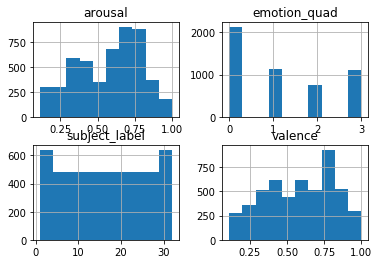

In [18]:
df.hist()

## Data loader

In [19]:
path=pathlib.Path('/media/tris/tris_files/EEG_datasets/DMD')
df = pd.read_csv(path/'labels_proc_window4.csv') #load labels
df.tail()

,file_name,subject_label,valence,arousal,emotion_quad
5115,S32T156,32,0.443333,0.796667,1.0
5116,S32T157,32,0.794444,0.447778,3.0
5117,S32T158,32,0.794444,0.447778,3.0
5118,S32T159,32,0.794444,0.447778,3.0
5119,S32T160,32,0.794444,0.447778,3.0


In [20]:
src = (ImageList.from_csv(path, 'labels_proc_window4.csv', folder='window_4times', suffix='.png')
       .split_by_rand_pct(0.2)
       .label_from_df(cols=['arousal']))

In [21]:
tfms=get_transforms(do_flip=False, flip_vert=False, max_rotate=0,max_zoom=1.1,max_lighting=0.3,p_affine=0)

In [22]:
data = (src.transform(tfms, size=250)
        .databunch(bs=4).normalize())

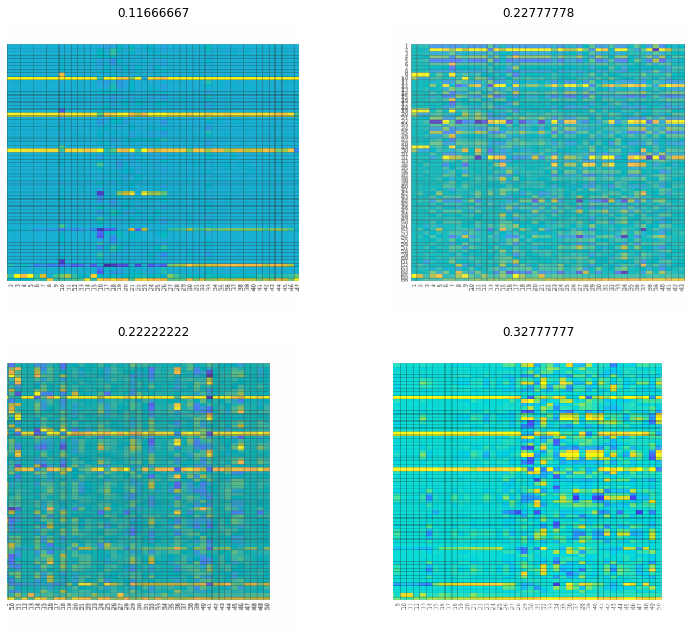

In [23]:
data.show_batch(rows=4, figsize=(12,9))

## Setup Network

In [24]:
learn = cnn_learner(data, models.resnet50, metrics=root_mean_squared_error)

In [25]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 125, 125]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 125, 125]       128        True      
______________________________________________________________________
ReLU                 [64, 125, 125]       0          False     
______________________________________________________________________
MaxPool2d            [64, 63, 63]         0          False     
______________________________________________________________________
Conv2d               [64, 63, 63]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 63, 63]         128        True      
______________________________________________________________________
Conv2d               [64, 63, 63]         36,864     False     
___________________________________________________

epoch,train_loss,valid_loss,root_mean_squared_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


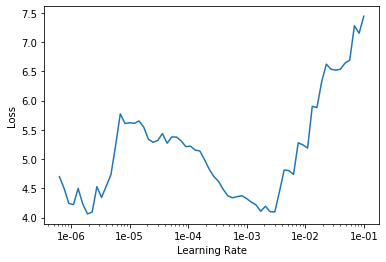

In [26]:
learn.lr_find()
learn.recorder.plot()

## Train last layers

In [27]:
lr = 3e-3
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.357008,0.119866,0.327926,01:04
1,0.181449,0.093888,0.285584,01:10
2,0.092846,0.058831,0.230135,01:04
3,0.060066,0.054646,0.220355,01:04
4,0.057240,0.045083,0.203161,01:03


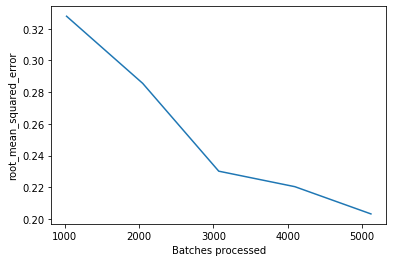

In [28]:
learn.recorder.plot_metrics()

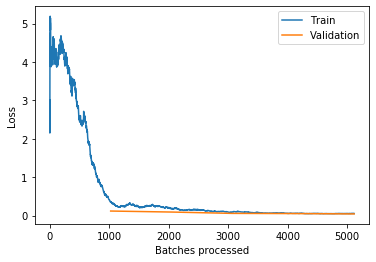

In [29]:
learn.recorder.plot_losses()

## Train the whole network

epoch,train_loss,valid_loss,root_mean_squared_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


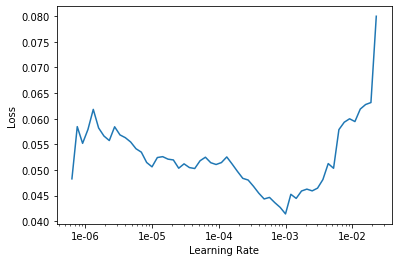

In [30]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [31]:
lr = 5e-4
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.054307,0.046595,0.207386,01:24
1,0.052648,0.046862,0.206851,01:23
2,0.051208,0.048242,0.209528,01:23
3,0.053183,0.043867,0.199699,01:25
4,0.051970,0.045973,0.200703,01:25
5,0.051227,0.044112,0.198609,01:26
6,0.050190,0.045306,0.202324,01:29
7,0.047246,0.040253,0.191027,01:27
8,0.044682,0.039232,0.189451,01:25
9,0.049979,0.038856,0.187680,01:26


## Interpret and Results

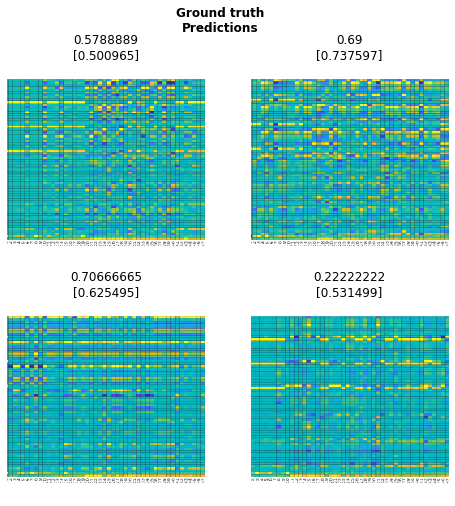

In [34]:
learn.show_results()

Ok, fully in the grind it out stage. Sit in this for a while, back to the drawing board.

In [36]:
?? learn.show_results